# DTSA 5511: Ecommerce Text Classification

## Project Overview

For this project, I will be analyzing the Ecommerce Text Classification dataset from Kaggle (linked below). The primary goal of this project will be to build a Deep Learning model that can accurately classify a text string. The string of text will include the product description from the item's website. Each of the products will then be classified into one of the four following categories: Household, Books, Clothing & Accessories, or Electronics.

In [2]:
#Importing Libraries & Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

## Ecommerce Text Data Set

As mentioned above, the dataset that will be used for this project was found from Kaggle and includes text strings and classifications. In the dataset, there are over 50,000 product descriptions with the item's corresponding classification.

https://www.kaggle.com/datasets/saurabhshahane/ecommerce-text-classification

In [32]:
#Loading Dataframe & Data Cleaning
df = pd.read_csv('/Users/jschlangen/Desktop/ecommerceDataset.csv', names=['class', 'text'])
df = df.dropna()

print(df.head())
print('')
print(df['class'].unique())
print('')
print(f'Dataframe Length: {len(df)}')

       class                                               text
0  Household  Paper Plane Design Framed Wall Hanging Motivat...
1  Household  SAF 'Floral' Framed Painting (Wood, 30 inch x ...
2  Household  SAF 'UV Textured Modern Art Print Framed' Pain...
3  Household  SAF Flower Print Framed Painting (Synthetic, 1...
4  Household  Incredible Gifts India Wooden Happy Birthday U...

['Household' 'Books' 'Clothing & Accessories' 'Electronics']

Dataframe Length: 50424


## Exploratory Data Analysis
Above, I ran a few print statements that can give us an initial glimpse into the dataset. Below are three visualizations that can help us better understand the underlying dataset.

The first visualization shows the count of each of the four classifcations in the dataset. We can see that the majority of the product descriptions are related to 'Household' items with the least representation from the 'Clothing & Accessories' category. All in all, the data is evenly distributed and we will have enough samples from each category to properly train our model.

In the violin plot, we are able to see the density and distribution of text length for each classification. The data in this visualization is interesting and also quite intuitive. Book descriptions are heavily centered around a short description with a very long tail in the positive direction. Electronics has a very widespread distribution, while the other 2 categories fall somewhere in between.

Lastly, I generated a wordcloud to gather a better understanding of the underlying words within the description. Again, there are not any major surprises presented in the wordcloud. We can see that the 'Books' category includes words such as 'Author' and 'World', while the 'Electronics' category includes words such as 'Device' and 'Use'.

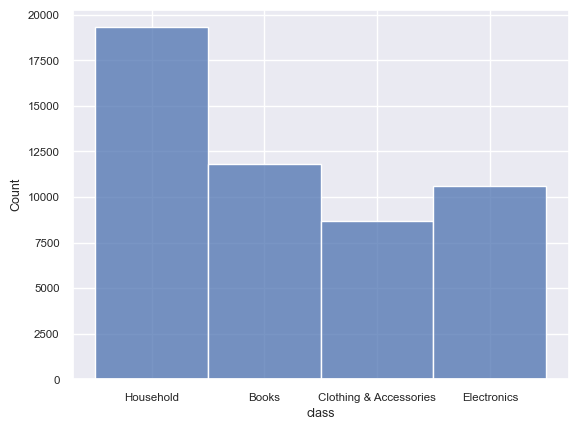

In [33]:
#Plotting Distribution of Product Descriptions
sns.set_theme(font_scale=0.75)
sns.histplot(data=df, x='class')
plt.show()

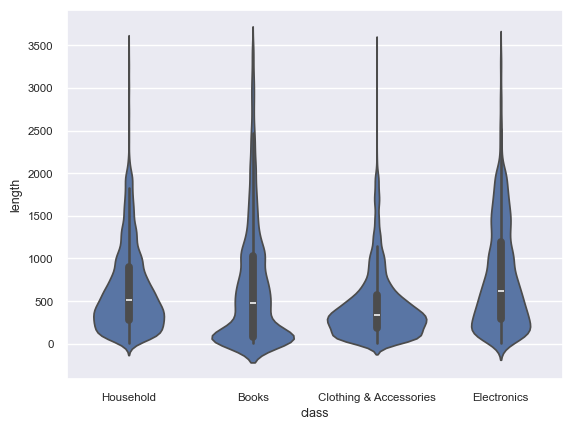

In [34]:
#Plotting Text Length Distribution by Ecommerce Category
plot_df = df
plot_df['length'] = plot_df['text'].apply(len)
plot_df = plot_df[(plot_df['length'] <= 3500)]

sns.set_theme(font_scale=0.75)
sns.violinplot(data=plot_df, x='class', y='length')
plt.show()

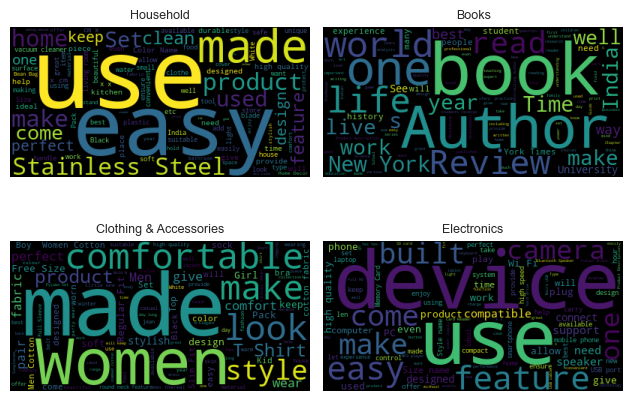

In [35]:
#Generating Word Cloud by Ecommerce Category
categories = df['class'].unique()

for i, cat in enumerate(categories):
    plt.subplot(2, 2, i + 1)
    string = " ".join(s for s in df[df['class'] == cat]['text'])
    
    wordcloud = WordCloud(max_words=100).generate(string)
    
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(cat)

plt.tight_layout()
plt.show()

## Data Cleaning & Preparation

As the dataset was already clean from Kaggle, there were not many steps that needed to be taken in this area.

A few key tasks that were performed include removing null values from the dataset and transforming the classification labels. The string classifications were replaced with integers by utilizing the LabelEncoder function from sklearn. I opted to complete this step after the exploratory data analysis (EDA) to use the string classification values in the above visualizations.

The last step in the data preparation process was to split the original dataframe into training and testing sets. Due to the large size of the dataset, I will be withholding the standard 20% for testing.

In [36]:
#More Data Cleaning, Split Train & Test Data
class_map = LabelEncoder()
df['class'] = class_map.fit_transform(df['class'])

train_df, test_df = train_test_split(df, test_size=0.2)

print(f'Training Dataframe Length: {len(train_df)}')
print(f'Testing Dataframe Length: {len(test_df)}')

Training Dataframe Length: 40339
Testing Dataframe Length: 10085


## Model Training & Validation

20% validation

In [56]:
#Processing Ecommerce Text with Tokenizer
max_words = 9999
max_length = 99

token = Tokenizer(num_words=max_words)
token.fit_on_texts(train_df['text'])
train_sequences = token.texts_to_sequences(train_df['text'])
x_train = pad_sequences(train_sequences, maxlen=max_length)
y_train = to_categorical(train_df['class'])

test_sequences = token.texts_to_sequences(test_df['text'])
x_test = pad_sequences(test_sequences, maxlen=max_length)

In [57]:
#Building Classification Model with Keras Sequential
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128))
model.add(LSTM(64, return_sequences=True))
model.add(GlobalMaxPooling1D())
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_3          │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [58]:
#Training Model & Generating Predictions
fit_hist = model.fit(x_train, y_train, epochs=5, batch_size=35, validation_split=0.2)

y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_df['class'].values

Epoch 1/5
923/923 ━━━━━━━━━━━━━━━━━━━━ 35s 37ms/step - accuracy: 0.7655 - loss: 0.5923 - val_accuracy: 0.9612 - val_loss: 0.1470
Epoch 2/5
923/923 ━━━━━━━━━━━━━━━━━━━━ 34s 37ms/step - accuracy: 0.9775 - loss: 0.0907 - val_accuracy: 0.9672 - val_loss: 0.1250
Epoch 3/5
923/923 ━━━━━━━━━━━━━━━━━━━━ 34s 36ms/step - accuracy: 0.9864 - loss: 0.0533 - val_accuracy: 0.9698 - val_loss: 0.1223
Epoch 4/5
923/923 ━━━━━━━━━━━━━━━━━━━━ 33s 36ms/step - accuracy: 0.9923 - loss: 0.0332 - val_accuracy: 0.9681 - val_loss: 0.1268
Epoch 5/5
923/923 ━━━━━━━━━━━━━━━━━━━━ 33s 36ms/step - accuracy: 0.9943 - loss: 0.0224 - val_accuracy: 0.9710 - val_loss: 0.1275
316/316 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


## Results & Conclusion

In terms of results, I am very satisfied with the performance of the CNN model that was constructed. After minor adjustment of hyperparameters, I was able to achieve a training accuracy score of over 99% and a validation accuracy score of 97%. These results are fantastic, especially for a problem requiring classification between 4 different categories. I am confident that over 99% validation accuracy could be achieved with a similar binary classification problem.

The first graph shows the change in accuracy and loss scores as Epochs increased. Training accuracy rose sharply after 1 epoch and increased slowly from that point. I did find it interesting that the validation accuracy decreased between the 3rd and 4th Epoch and plan to research this further in the future. As for loss scores, they dropped sharply on the training set while being largely unchanged with the validation data.

In the plot of the confusion matrix, it is most clear to me that the CNN model performs incredibly well at properly classifying text with over 97% accuracy again. My second takeaway is that the 'Household' category had the largest prediction error and most crossover with the other categories. In hindsight, this does make sense, because 'Household' category is the broadest and these products could exist in some of the other categories.

For future testing, I would be curious to try solving this problem using a binary classifcation solution. Doing this would allow me to achieve greater accuracy and greater speed in the performance of this model. With all that said, I am incredibly happy overall with the strong performance and results of this project.

In [96]:
train_acc = max(fit_hist.history['accuracy'])
val_acc = max(fit_hist.history['val_accuracy'])

print(f'Training Accuracy: {train_acc}')
print(f'Validation Accuracy: {val_acc}')

Training Accuracy: 0.9935855865478516
Validation Accuracy: 0.9709965586662292


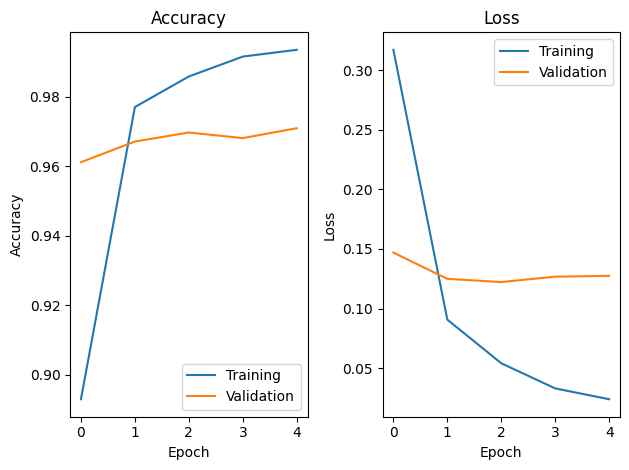

In [59]:
#Plotting Accuracy & Loss Data
plt.subplot(1, 2, 1)
plt.plot(fit_hist.history['accuracy'], label='Training')
plt.plot(fit_hist.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(fit_hist.history['loss'], label='Training')
plt.plot(fit_hist.history['val_loss'], label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

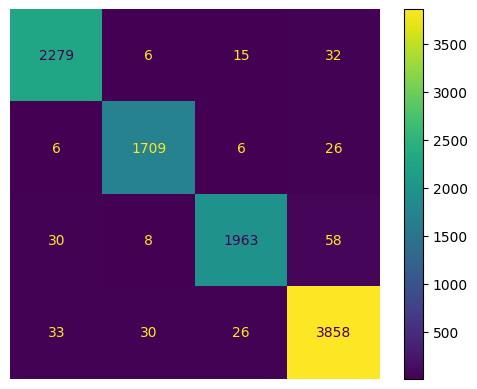

In [60]:
#Create & Plot Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_map.classes_)
cm.plot()
plt.axis('off')
plt.show()